In [1]:
import torch
from torch import nn
import numpy as np
import matplotlib.pyplot as plt

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
import csv
data = []
with open("cleaned/FL.csv", "r", encoding="utf-8") as f:
    csv_reader = csv.reader(f, delimiter=',')
    headers = next(csv_reader)
    for i in csv_reader:
        data.append(int(i[5]))

train  = data[:-200]
test = data[-200:]

li_x = []
li_y = []
seq = 2

# 因为数据集较少，序列长度太长会影响结果
for i in range(len(data[:-200]) - seq):
    # 输入就是[x,x+1]天的数据，输出时x+2天的数据
    li_x.append(train[i: i+seq])
    li_y.append(train[i+seq])

t_x = []
t_y = []
# 因为数据集较少，序列长度太长会影响结果
for i in range(len(data[-200:]) - seq):
    # 输入就是[x,x+1]天的数据，输出时x+2天的数据*
    t_x.append(test[i: i+seq])
    t_y.append(test[i+seq])

# print(li_x)
# print(li_y)

# 分训练和测试集
train_x = (torch.tensor(li_x).float() / 1000.).reshape(-1, seq, 1).to(device)
train_y = (torch.tensor(li_y).float() / 1000.).reshape(-1, 1).to(device)

print(train_x.shape)

test_x = (torch.tensor(t_x).float() / 1000.).reshape(-1, seq, 1).to(device)
test_y = (torch.tensor(t_y).float() / 1000.).reshape(-1, 1).to(device)

torch.Size([508, 2, 1])


In [4]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.lstm = nn.LSTM(input_size=1, hidden_size=32, num_layers=1, batch_first=True)
        # 输入格式是1，输出隐藏层大小是32
        # 对于小数据集num_layers不要设置大，否则会因为模型变复杂而导致效果会变差
        # num_layers顾名思义就是有几个lstm层，假如设置成2，就相当于连续经过两个lstm层
        # 原来的输入格式是：(seq, batch, shape)
        # 设置batch_first=True以后，输入格式就可以改为：(batch, seq, shape)，更符合平常使用的习惯
        self.linear = nn.Linear(32*seq, 1)

    def forward(self, x):
        x, (h, c) = self.lstm(x)
        x = x.reshape(-1, 32*seq)
        x = self.linear(x)
        return x

In [5]:
model = Net().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.003)
loss_fun = nn.MSELoss()

In [6]:
model.train()
for epoch in range(3000):
    output = model(train_x)
    loss = loss_fun(output, train_y)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    if epoch % 20 == 0 and epoch > 0:
        test_loss = loss_fun(model(test_x), test_y)
        print("epoch:{}, loss:{}, test_loss: {}".format(epoch, loss, test_loss))

epoch:20, loss:22.24441146850586, test_loss: 176.68777465820312
epoch:40, loss:8.285479545593262, test_loss: 126.45670318603516
epoch:60, loss:4.9851603507995605, test_loss: 101.10783386230469
epoch:80, loss:3.3394715785980225, test_loss: 91.11688995361328
epoch:100, loss:2.6855030059814453, test_loss: 81.61683654785156
epoch:120, loss:2.3620142936706543, test_loss: 75.70332336425781
epoch:140, loss:2.2103099822998047, test_loss: 72.09796142578125
epoch:160, loss:2.1322319507598877, test_loss: 69.68635559082031
epoch:180, loss:2.0891895294189453, test_loss: 68.05351257324219
epoch:200, loss:2.0618112087249756, test_loss: 66.82780456542969
epoch:220, loss:2.042708396911621, test_loss: 65.89654541015625
epoch:240, loss:2.028090715408325, test_loss: 65.19954681396484
epoch:260, loss:2.016324758529663, test_loss: 64.67524719238281
epoch:280, loss:2.006181001663208, test_loss: 64.24516296386719
epoch:300, loss:1.9970839023590088, test_loss: 63.868804931640625
epoch:320, loss:1.9886087179183

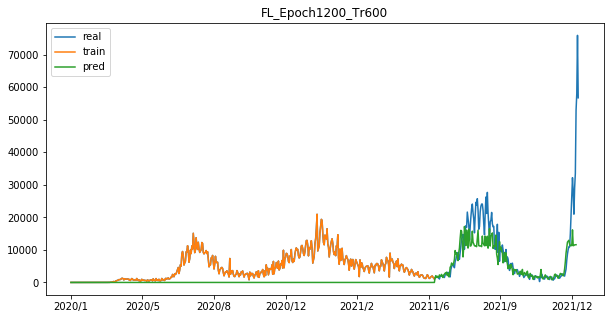

In [7]:
model.eval()
# result = li_x[0][:seq-1] + list((model(train_x).data.reshape(-1))*1000) + list((model(test_x).data.reshape(-1))*1000)
result = [0] + list((model(train_x).data.reshape(-1))*00) + list((model(test_x).data.reshape(-1))*1000)

#展示结果
plt.figure(figsize=(10,5))

plt.plot(data,label="real")
# 原来的走势

plt.plot(train,label="train")

plt.plot(result,label="pred")
plt.xticks(
    [0,100,200,300,400,500,600,700],
    ['2020/1','2020/5', '2020/8', '2020/12', '2021/2', '20211/6', '2021/9', '2021/12']
)
# 模型预测的走势
plt.legend(loc='best')
plt.title('FL_Epoch1200_Tr600')
# plt.savefig('plot/FL_Epoch1200_Tr600.jpg')
plt.show()

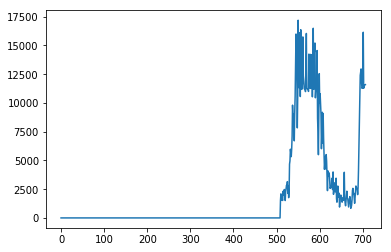

In [8]:
plt.plot(result)

In [9]:
# prediction = result[400:700]
# real = data[400:700]

# from sklearn.metrics import mean_squared_error
# MSE = mean_squared_error(real, prediction)
# RMSE = MSE ** 0.5
# print("MSE:", MSE)
# print("RMSE", RMSE)

                  MSE         RMSE
200:300  4.513040e+06  2124.391751
300:400  9.345359e+06  3057.017989
400:500  2.125294e+06  1457.838872
500:600  3.761253e+07  6132.905443
600:700  2.556825e+06  1599.007396


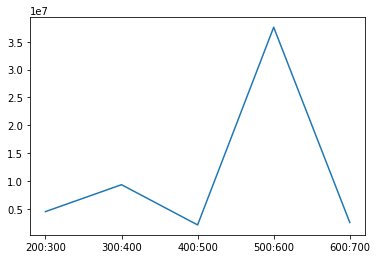

In [16]:
#Tr Size: 200 days
import pandas as pd
info = ['200:300', '300:400', '400:500', '500:600', '600:700']
MSE_list = [4513040.31369507, 9345358.983941305, 2125294.17701694, 37612529.172058195, 2556824.651083408]
RMSE_list = [2124.3917514655977, 3057.0179888154576, 1457.8388721038207, 6132.905442941233, 1599.0073955687035]

DF = pd.DataFrame({'MSE': MSE_list, 'RMSE': RMSE_list}, index=info)
print(DF)
plt.plot(DF.MSE)

In [11]:
#Tr Size: 300 days
info = ['300:400', '400:500', '500:600', '600:700']
MSE_list = [15859510.681514425, 3086902.190155774, 42523704.73638685, 3529988.249845526]
RMSE_list = [3982.4001156983745, 1756.958220947719, 6521.02022205014, 1878.8262958148969]

In [12]:
#Tr Size: 400 days
info = ['400:500', '500:600', '600:700']
MSE_list = [4338729.452249858, 38993566.927481525, 3568011.513790344]
RMSE_list = [2082.9617020602795, 6244.4829191440285, 1888.9180802222058]

In [13]:
#Tr Size: 500 days
info = ['500:600', '600:700']
MSE_list = [29760939.82130769, 2635325.4543793853]
RMSE_list = [5455.358816916417, 1623.3685516170951]

In [14]:
from sklearn.metrics import mean_squared_error
temp_MSE = []
temp_RMSE = []
for i in range(500,700,100):
    MSE = mean_squared_error(result[i:i+100], data[i:i+100])
    temp_MSE.append(MSE)
    RMSE = MSE ** 0.5
    temp_RMSE.append(RMSE)
print(temp_MSE)
print(temp_RMSE)

[33206926.149028026, 2840312.6148895323]
[5762.5451103681635, 1685.322703487238]


C:\Users\goodr\anaconda3\envs\mll\lib\site-packages\sklearn\utils\validation.py:63: FutureWarning: Arrays of bytes/strings is being converted to decimal numbers if dtype='numeric'. This behavior is deprecated in 0.24 and will be removed in 1.1 (renaming of 0.26). Please convert your data to numeric values explicitly instead.
  return f(*args, **kwargs)
C:\Users\goodr\anaconda3\envs\mll\lib\site-packages\sklearn\utils\validation.py:63: FutureWarning: Arrays of bytes/strings is being converted to decimal numbers if dtype='numeric'. This behavior is deprecated in 0.24 and will be removed in 1.1 (renaming of 0.26). Please convert your data to numeric values explicitly instead.
  return f(*args, **kwargs)
